In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.raster_helper_functions import *
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
df_thwaites = pd.read_csv('thwaites_baseline_geo_2_1.csv')
df_pig = pd.read_csv('pig_baseline_geo_9_2_1.csv')
df_dotson = pd.read_csv('dotson_baseline_geo_9_2_1.csv')

In [3]:
def compute_vel(df):
    df['vel_mag_initial'] = np.sqrt(df['x_velocity_initial']**2 + df['y_velocity_initial']**2)
    df['vel_mag_sim'] = np.sqrt(df['x_velocity']**2 + df['y_velocity']**2)

In [4]:
compute_vel(df_thwaites)
compute_vel(df_pig)
compute_vel(df_dotson)

In [5]:
df_thwaites.columns

Index(['Unnamed: 0', 'theta', 'C', 'C_total', 'x', 'y', 's11', 's12', 's21',
       's22', 'grad_h_1', 'grad_h_2', 'grad_s_1', 'grad_s_2', 'grad_b_1',
       'grad_b_2', 'x_velocity', 'y_velocity', 'x_velocity_initial',
       'y_velocity_initial', 'err_x', 'err_y', 'h', 's', 'b', 'mag_anomaly',
       'boug_anomaly', 'heatflux', 'invariant1', 'invariant2', 'mag_h',
       'mag_s', 'mag_b', 'total_u_error', 'vel_mag', 'driving_stress',
       'vel_mag_initial', 'vel_mag_sim'],
      dtype='object')

In [6]:
# Prepare data for multi-fidelity model
# High fidelity data
#X_high = df_free_air[['x', 'y']].values
#Y_high = df_free_air['free_air_gravity_anomaly'].values.reshape(-1, 1)
input_columns = ['h', 's', 'b', 'mag_h', 'mag_s', 'mag_b', 'driving_stress'] #, 'mag_anomaly', 'heatflux']

X_high = np.vstack([df_thwaites[input_columns].values, df_dotson[input_columns].values])
Y_high = np.vstack([df_thwaites['vel_mag_initial'].values.reshape(-1, 1), df_dotson['vel_mag_initial'].values.reshape(-1, 1)])


Y_low = np.vstack([df_thwaites['vel_mag_sim'].values.reshape(-1, 1), df_dotson['vel_mag_sim'].values.reshape(-1, 1)])

# Split data into train and test sets
X_high_train, X_high_test, Y_high_train, Y_high_test, Y_low_train, Y_low_test = train_test_split(X_high, Y_high, Y_low, test_size=0.2, random_state=42)

In [7]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=70, min_lr=0.00001) # 40
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=150, #100
    restore_best_weights=True)

In [8]:
# Define high fidelity model
neurons = 200   # Number of neurons in each hidden layer
input_high = Input(shape=(len(input_columns),), name='high_fidelity_input')
x_high = Dense(neurons, activation='relu')(input_high)
for _ in range(20):
    x_high = Dense(neurons, activation='relu')(x_high)
output_high = Dense(1, name='high_fidelity_output')(x_high)
model_high = Model(inputs=input_high, outputs=output_high)

# Compile high fidelity model
model_high.compile(optimizer='adam', loss='mse')

# Train high fidelity model
history_high = model_high.fit(X_high_train, Y_high_train, epochs=2000, batch_size=128, verbose=1, validation_split=0.1, shuffle=True, callbacks=[reduce_lr, early_stopping])

high_fidelity_predictions_train_hf = model_high.predict(X_high_train)
high_fidelity_predictions_test_hf = model_high.predict(X_high_test)

r2 = r2_score(high_fidelity_predictions_test_hf, Y_high_test)

Epoch 1/2000
5871/5871 [==============================] - 28s 4ms/step - loss: 42009.9141 - val_loss: 39972.4609 - lr: 0.0010
Epoch 2/2000
5871/5871 [==============================] - 28s 5ms/step - loss: 39192.6719 - val_loss: 41585.5391 - lr: 0.0010
Epoch 3/2000
5871/5871 [==============================] - 27s 5ms/step - loss: 147380.0625 - val_loss: 37782.8281 - lr: 0.0010
Epoch 4/2000
5871/5871 [==============================] - 25s 4ms/step - loss: 38333.4922 - val_loss: 37831.9219 - lr: 0.0010
Epoch 5/2000
5871/5871 [==============================] - 25s 4ms/step - loss: 38436.7852 - val_loss: 38279.6445 - lr: 0.0010
Epoch 6/2000
5871/5871 [==============================] - 25s 4ms/step - loss: 39453.3828 - val_loss: 37841.6133 - lr: 0.0010
Epoch 7/2000
5871/5871 [==============================] - 26s 4ms/step - loss: 910756.1875 - val_loss: 37966.7344 - lr: 0.0010
Epoch 8/2000
5871/5871 [==============================] - 25s 4ms/step - loss: 36891.5312 - val_loss: 36536.4961 - l

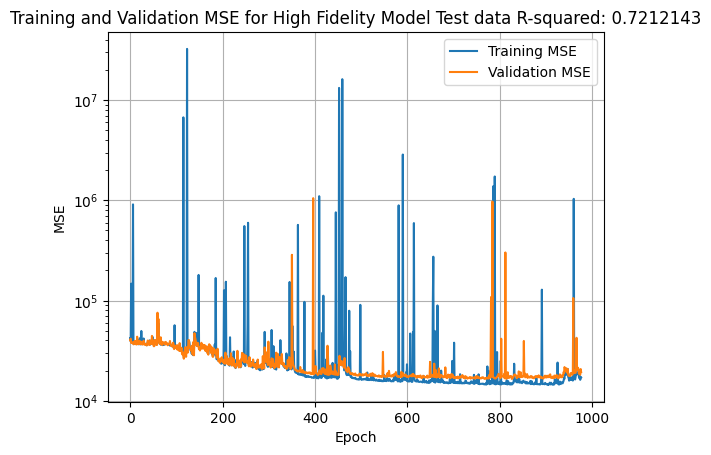

In [9]:
# Plot training and validation loss
plt.grid()
plt.semilogy(history_high.history['loss'], label='Training MSE')
plt.semilogy(history_high.history['val_loss'], label='Validation MSE')
plt.title('Training and Validation MSE for High Fidelity Model'+ ' Test data R-squared: {:.7f}'.format(r2))
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [10]:
# Combine low fidelity predictions with high fidelity inputs
combined_input_train = np.hstack([X_high_train, Y_low_train])
combined_input_test = np.hstack([X_high_test, Y_low_test])

# Redefine high fidelity model with additional input from low fidelity predictions
neurons = 200 # Number of neurons in each hidden layer
input_combined = Input(shape=(len(input_columns) + 1,), name='combined_input')
x_combined = Dense(neurons, activation='relu')(input_combined)
for _ in range(30):
    x_combined = Dense(neurons, activation='relu')(x_combined)
output_combined = Dense(1, name='combined_output')(x_combined)
model_combined = Model(inputs=input_combined, outputs=output_combined)

# Compile combined model
model_combined.compile(optimizer='adam', loss='mse')

# Train combined model with combined inputs
history_combined = model_combined.fit(combined_input_train, Y_high_train, epochs=2000, batch_size=128, verbose=1, validation_split=0.1, shuffle=True, callbacks=[reduce_lr, early_stopping])

# Predict using multi-fidelity model

final_predictions_test_high = model_combined.predict(np.hstack([X_high_test, Y_low_test]))
final_predictions_train_high = model_combined.predict(np.hstack([X_high_train, Y_low_train]))

r2 = r2_score(final_predictions_test_high, Y_high_test)

Epoch 1/2000
5871/5871 [==============================] - 35s 6ms/step - loss: 31983.1680 - val_loss: 24086.1309 - lr: 0.0010
Epoch 2/2000
5871/5871 [==============================] - 33s 6ms/step - loss: 26261.3574 - val_loss: 30491.7754 - lr: 0.0010
Epoch 3/2000
5871/5871 [==============================] - 33s 6ms/step - loss: 24923.5703 - val_loss: 24625.7461 - lr: 0.0010
Epoch 4/2000
5871/5871 [==============================] - 34s 6ms/step - loss: 24640.0332 - val_loss: 22328.3711 - lr: 0.0010
Epoch 5/2000
5871/5871 [==============================] - 34s 6ms/step - loss: 23981.1680 - val_loss: 22228.3652 - lr: 0.0010
Epoch 6/2000
5871/5871 [==============================] - 34s 6ms/step - loss: 23324.1074 - val_loss: 22133.4668 - lr: 0.0010
Epoch 7/2000
5871/5871 [==============================] - 34s 6ms/step - loss: 22743.2598 - val_loss: 20619.6660 - lr: 0.0010
Epoch 8/2000
5871/5871 [==============================] - 34s 6ms/step - loss: 22715.1543 - val_loss: 23826.2891 - lr:

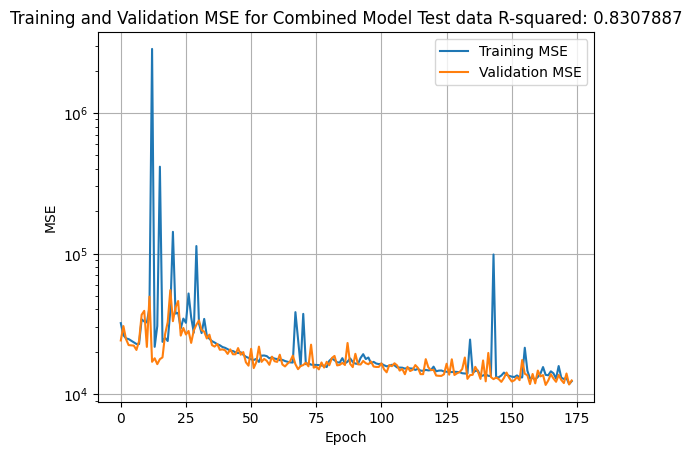

In [11]:
# Plot training and validation loss
plt.grid()
plt.semilogy(history_combined.history['loss'], label='Training MSE')
plt.semilogy(history_combined.history['val_loss'], label='Validation MSE')
plt.title('Training and Validation MSE for Combined Model' + ' Test data R-squared: {:.7f}'.format(r2))
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

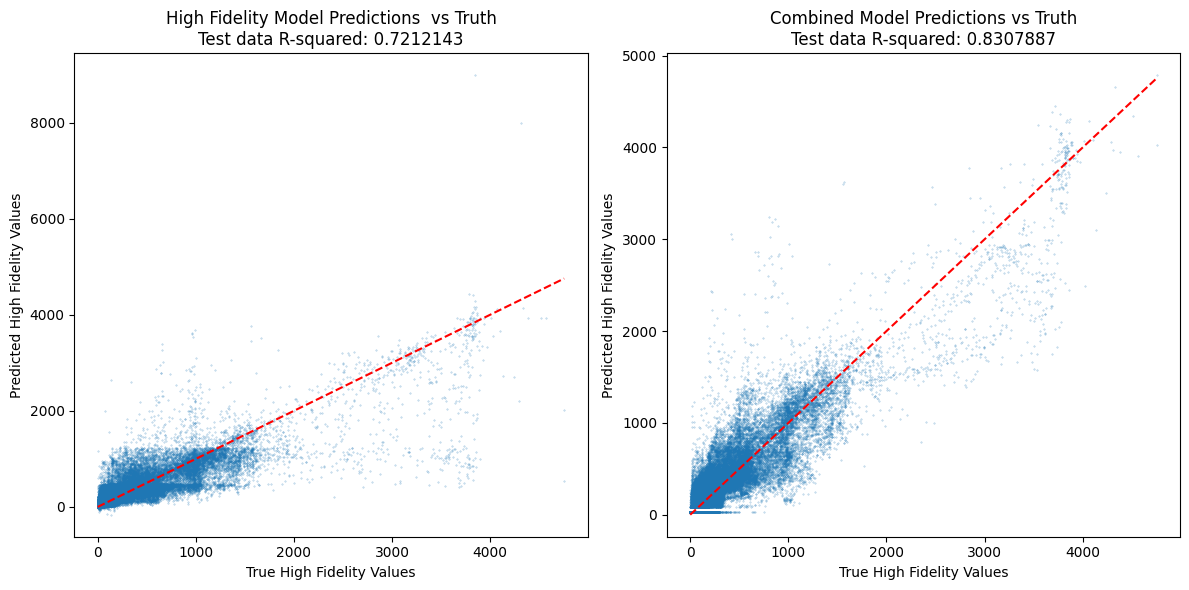

In [12]:
# Plotting predictions vs truth for low fidelity model
plt.figure(figsize=(12, 6))  # Set an appropriate figure size

# Plotting predictions vs truth for high fidelity model
plt.subplot(1, 2, 1)  # Corrected the subplot arguments to create a 1x2 grid, and select the first subplot
r2 = r2_score(high_fidelity_predictions_test_hf, Y_high_test)
plt.scatter(Y_high_test, high_fidelity_predictions_test_hf, alpha=0.5, s=0.1)
plt.plot([min(Y_high_test), max(Y_high_test)], [min(Y_high_test), max(Y_high_test)], color='red', linestyle='--')
plt.xlabel('True High Fidelity Values')
plt.ylabel('Predicted High Fidelity Values')
plt.title('High Fidelity Model Predictions  vs Truth\nTest data R-squared: {:.7f}'.format(r2))

# Plotting predictions vs truth for combined model
plt.subplot(1, 2, 2)  # Corrected the subplot arguments to select the second subplot
r2 = r2_score(final_predictions_test_high, Y_high_test)
plt.scatter(Y_high_test, final_predictions_test_high, alpha=0.5, s=0.1)
plt.plot([min(Y_high_test), max(Y_high_test)], [min(Y_high_test), max(Y_high_test)], color='red', linestyle='--')
plt.xlabel('True High Fidelity Values')
plt.ylabel('Predicted High Fidelity Values')  # Fixed the label from `xlabel` to `ylabel`
plt.title('Combined Model Predictions vs Truth\nTest data R-squared: {:.7f}'.format(r2))

plt.tight_layout()
plt.show()

In [13]:
high_fidelity_pred = model_high.predict(X_high)
combined_pred = model_combined.predict(np.hstack([X_high, Y_low]))

32614/32614 [==============================] - 55s 2ms/step


Mean Error Single-fidelity Model: 42.51816865570254
Mean Error Multifidelity Model: 52.15607704461817


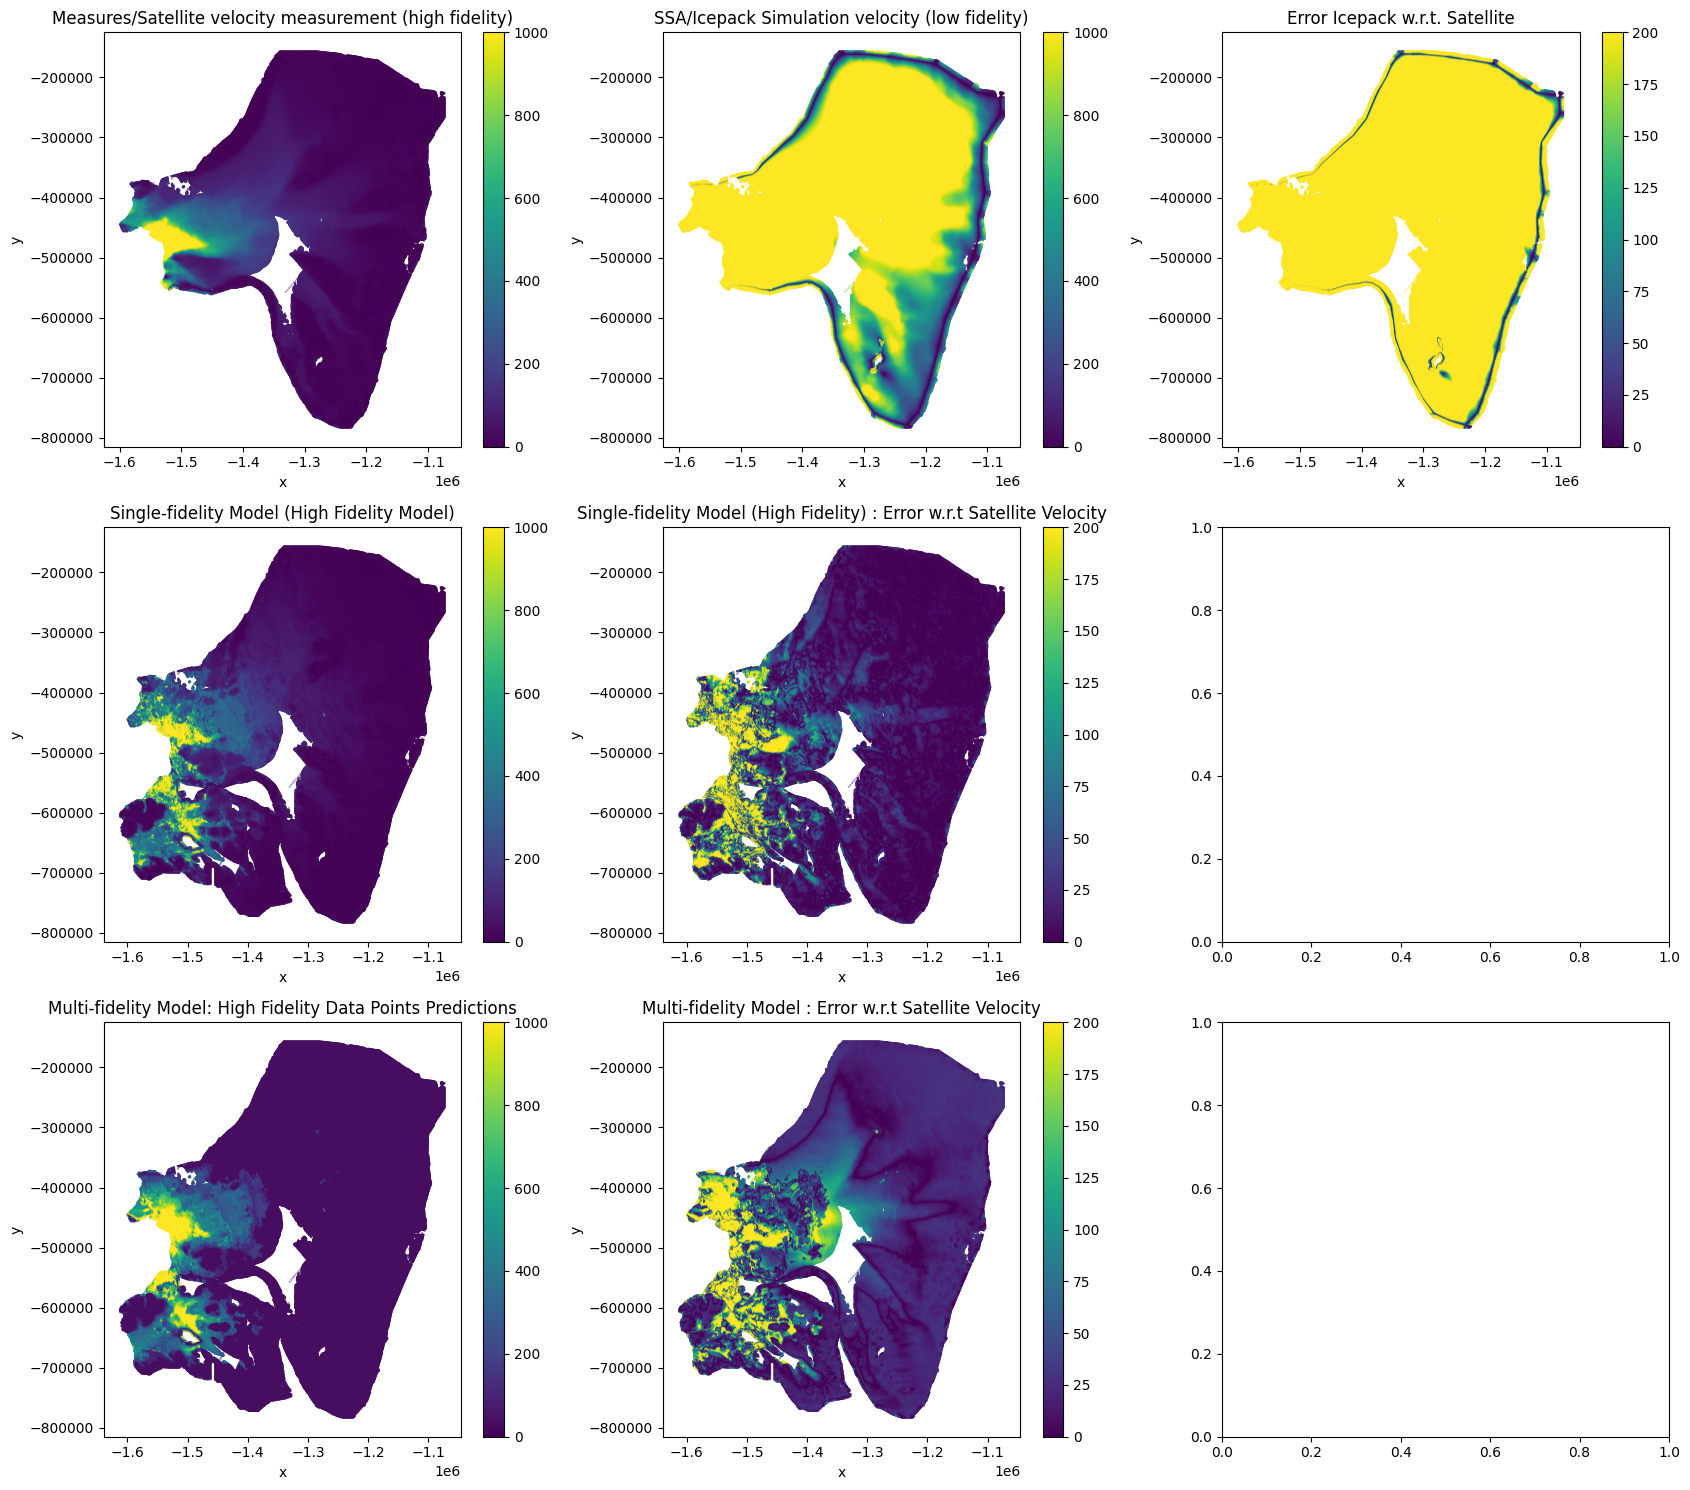

In [17]:
fig, ax = plt.subplots(3, 3, figsize=(17, 15))

# Plot 1: Measures/Satellite velocity measurement (high fidelity)
scatter_plot = ax[0, 0].scatter(df_thwaites['x'], df_thwaites['y'], c=df_thwaites['vel_mag_initial'], s=0.01)
fig.colorbar(scatter_plot, ax=ax[0, 0])
scatter_plot.set_clim(vmin=0, vmax=1000)
ax[0, 0].set_title('Measures/Satellite velocity measurement (high fidelity)')
ax[0, 0].set_xlabel('x')
ax[0, 0].set_ylabel('y')

# Plot 2: SSA/Icepack Simulation velocity (low fidelity)
scatter_plot = ax[0, 1].scatter(df_thwaites['x'], df_thwaites['y'], c=df_thwaites['vel_mag_sim'],  s=0.01)
fig.colorbar(scatter_plot, ax=ax[0, 1])
scatter_plot.set_clim(vmin=0, vmax=1000)
ax[0, 1].set_title('SSA/Icepack Simulation velocity (low fidelity)')
ax[0, 1].set_xlabel('x')
ax[0, 1].set_ylabel('y')

# Plot 3: Error (Icepack vs. Satellite)
error = np.sqrt(np.square(df_thwaites['vel_mag_sim'] - df_thwaites['vel_mag_initial']))
scatter_plot = ax[0, 2].scatter(df_thwaites['x'], df_thwaites['y'], c=error,  s=0.01)
fig.colorbar(scatter_plot, ax=ax[0, 2])
scatter_plot.set_clim(vmin=0, vmax=200)
ax[0, 2].set_title('Error Icepack w.r.t. Satellite')
ax[0, 2].set_xlabel('x')
ax[0, 2].set_ylabel('y')


# Plot 4: Single-fidelity Model (High Fidelity Model)
scatter_plot = ax[1, 0].scatter(np.concatenate((df_thwaites['x'], df_dotson['x'])), 
                                np.concatenate((df_thwaites['y'], df_dotson['y'])), 
                                c=high_fidelity_pred, s=0.01)
fig.colorbar(scatter_plot, ax=ax[1, 0])
scatter_plot.set_clim(vmin=0, vmax=1000)
ax[1, 0].set_title('Single-fidelity Model (High Fidelity Model)')
ax[1, 0].set_xlabel('x')
ax[1, 0].set_ylabel('y')

# Plot 5: Error (Single-fidelity Model)

# Concatenate the relevant velocity magnitudes from the two datasets
vel_mag_initial_concat = np.concatenate((df_thwaites['vel_mag_initial'], df_dotson['vel_mag_initial']))

high_fidelity_pred = high_fidelity_pred.flatten()

# Ensure that the concatenated array and predictions are both 1D and of the same length
assert high_fidelity_pred.shape == vel_mag_initial_concat.shape, "Shape mismatch between high fidelity predictions and initial velocity data."

# Calculate the error between the high fidelity predictions and the true values
error = np.sqrt(np.square(high_fidelity_pred - vel_mag_initial_concat))

# Calculate the mean error
mean_error = np.mean(error)
print("Mean Error Single-fidelity Model:", mean_error)

# Create the scatter plot for the error
scatter_plot_train = ax[1, 1].scatter(np.concatenate((df_thwaites['x'], df_dotson['x'])), 
                                      np.concatenate((df_thwaites['y'], df_dotson['y'])), 
                                      c=error, s=0.01)

# Add a colorbar to the plot
fig.colorbar(scatter_plot_train, ax=ax[1, 1])

# Set the color limits for the plot
scatter_plot_train.set_clim(vmin=0, vmax=200)

# Set the title and labels for the plot
ax[1, 1].set_title('Single-fidelity Model (High Fidelity) : Error w.r.t Satellite Velocity')
ax[1, 1].set_xlabel('x')
ax[1, 1].set_ylabel('y')

# Plot 6: Final Predictions (Multi-fidelity Model)
scatter_plot_train = ax[2, 0].scatter(np.concatenate((df_thwaites['x'], df_dotson['x'])), 
                                      np.concatenate((df_thwaites['y'], df_dotson['y'])), 
                                      c=combined_pred, s=0.01)
fig.colorbar(scatter_plot_train, ax=ax[2, 0])
scatter_plot_train.set_clim(vmin=0, vmax=1000)
ax[2, 0].set_title('Multi-fidelity Model: High Fidelity Data Points Predictions')
ax[2, 0].set_xlabel('x')
ax[2, 0].set_ylabel('y')


# Plot 6: Multi-fidelity Model Error
# Concatenate the relevant velocity magnitudes from the two datasets
vel_mag_initial_concat = np.concatenate((df_thwaites['vel_mag_initial'], df_dotson['vel_mag_initial']))

combined_pred = combined_pred.flatten()

# Ensure that the concatenated array and combined predictions are both 1D and of the same length
assert combined_pred.shape == vel_mag_initial_concat.shape, "Shape mismatch between combined predictions and initial velocity data."

# Calculate the error between the combined predictions and the true values
error = np.sqrt(np.square(combined_pred - vel_mag_initial_concat))

# Calculate the mean error
mean_error = np.mean(error)
print("Mean Error Multifidelity Model:", mean_error)

# Create the scatter plot for the error
scatter_plot_train = ax[2, 1].scatter(np.concatenate((df_thwaites['x'], df_dotson['x'])), 
                                      np.concatenate((df_thwaites['y'], df_dotson['y'])), 
                                      c=error, s=0.01)

# Add a colorbar to the plot
fig.colorbar(scatter_plot_train, ax=ax[2, 1])

# Set the color limits for the plot
scatter_plot_train.set_clim(vmin=0, vmax=200)

# Set the title and labels for the plot
ax[2, 1].set_title('Multi-fidelity Model : Error w.r.t Satellite Velocity')
ax[2, 1].set_xlabel('x')
ax[2, 1].set_ylabel('y')


plt.tight_layout()
plt.show()


In [ ]:
X_pig = df_pig[input_columns].values
Y_pig_high = df_pig['vel_mag_initial'].values.reshape(-1, 1)
Y_pig_low = df_pig['vel_mag_sim'].values.reshape(-1, 1)

high_fidelity_predictions_pig = model_high.predict(X_pig)

# Combine low fidelity predictions with high fidelity inputs
combined_input_pig = np.hstack([X_pig,Y_pig_low])

multifidelity_predictions = model_combined.predict(combined_input_pig)

6471/6471 [==============================] - 12s 2ms/step
Mean Error Single-fidelity Model: 320.48367296828036
Mean Error Multi-fidelity Model: 359.1941293457601


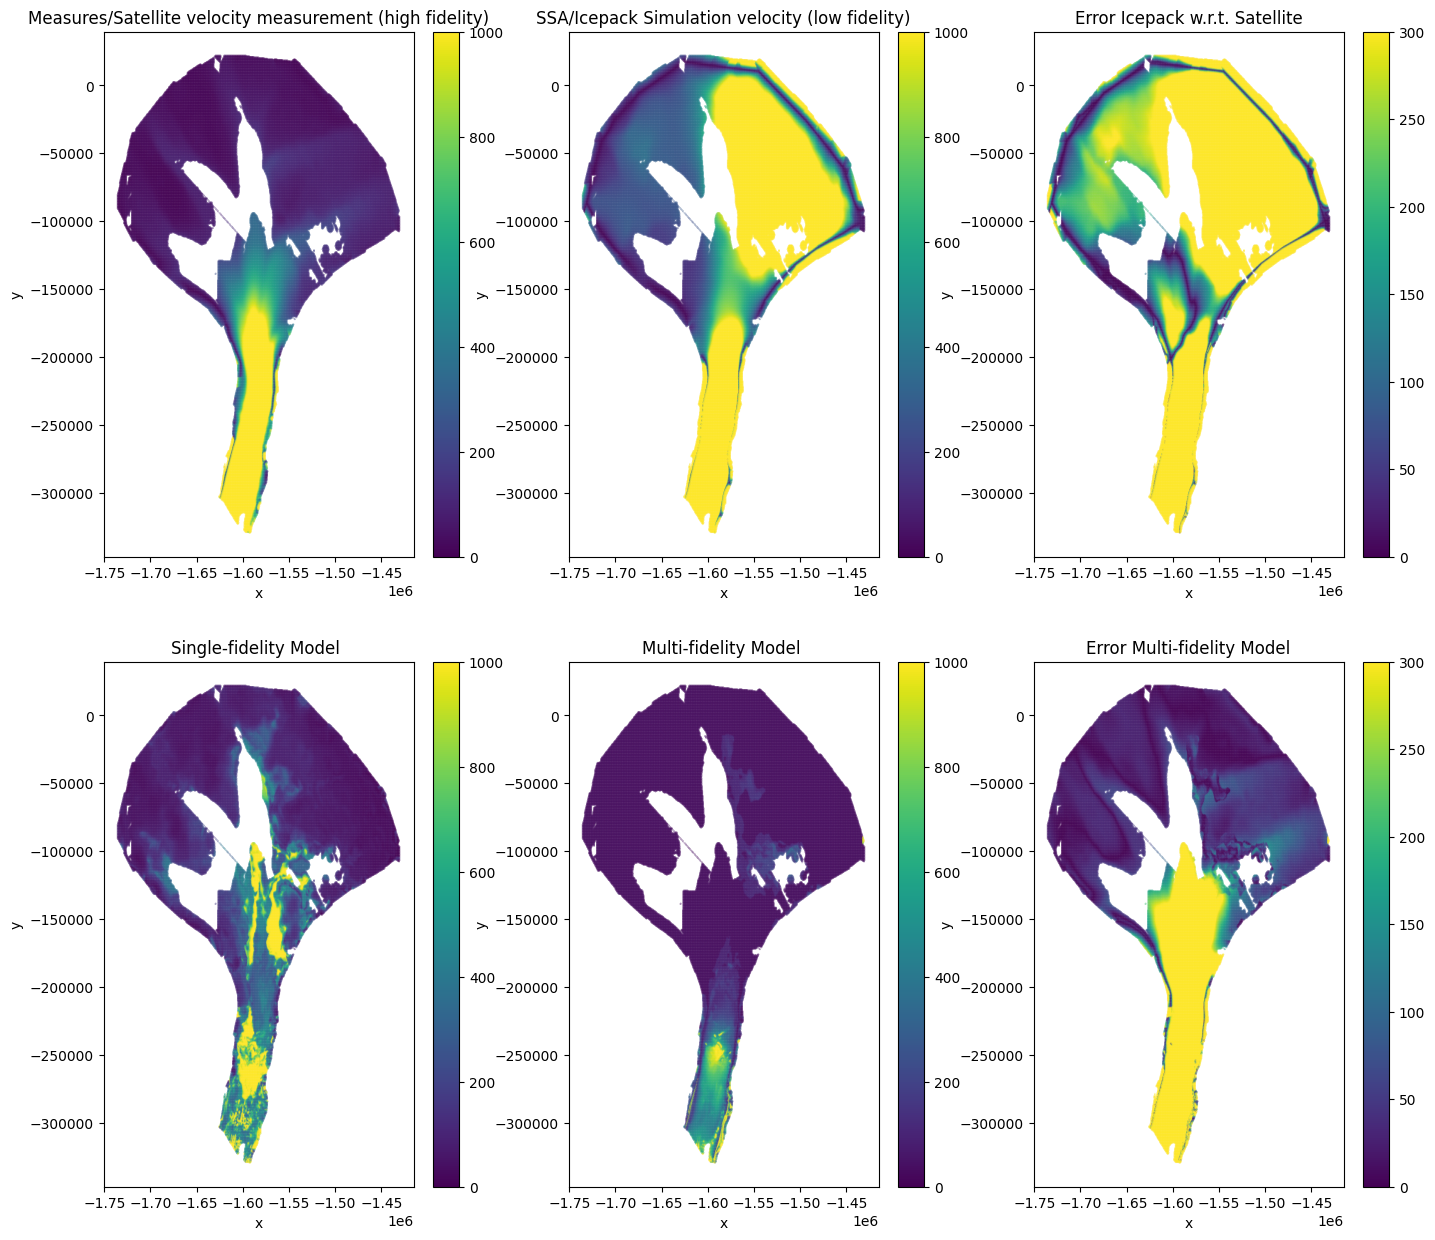

In [18]:
fig, ax = plt.subplots(2, 3, figsize=(17, 15))

# Plot 1: Satellite Velocity Measurement
scatter_plot = ax[0, 0].scatter(df_pig['x'], df_pig['y'], c=df_pig['vel_mag_initial'], s=0.01)
fig.colorbar(scatter_plot, ax=ax[0, 0])
scatter_plot.set_clim(vmin=0, vmax=1000)
ax[0, 0].set_title('Measures/Satellite velocity measurement (high fidelity)')
ax[0, 0].set_xlabel('x')
ax[0, 0].set_ylabel('y')

# Plot 2: Icepack Simulation Velocity
scatter_plot = ax[0, 1].scatter(df_pig['x'], df_pig['y'], c=df_pig['vel_mag_sim'],  s=0.01)
fig.colorbar(scatter_plot, ax=ax[0, 1])
scatter_plot.set_clim(vmin=0, vmax=1000)
ax[0, 1].set_title('SSA/Icepack Simulation velocity (low fidelity)')
ax[0, 1].set_xlabel('x')
ax[0, 1].set_ylabel('y')

# Plot 3: Error
error = np.sqrt(np.square(df_pig['vel_mag_sim'] - df_pig['vel_mag_initial']))
scatter_plot = ax[0, 2].scatter(df_pig['x'], df_pig['y'], c=error,  s=0.01)
fig.colorbar(scatter_plot, ax=ax[0, 2])
scatter_plot.set_clim(vmin=0, vmax=300)
ax[0, 2].set_title('Error Icepack w.r.t. Satellite')
ax[0, 2].set_xlabel('x')
ax[0, 2].set_ylabel('y')

# Plot 4: High Fidelity
scatter_plot_train = ax[1, 0].scatter(df_pig['x'], df_pig['y'], c=high_fidelity_predictions_pig, s=0.01)
fig.colorbar(scatter_plot_train, ax=ax[1, 0])
scatter_plot_train.set_clim(vmin= 0, vmax= 1000)
ax[1, 0].set_title('Single-fidelity Model ')
ax[1, 0].set_xlabel('x')
ax[1, 0].set_ylabel('y')

# Plot 4: High Fidelity
scatter_plot_train = ax[1, 1].scatter(df_pig['x'], df_pig['y'], c=multifidelity_predictions , s=0.01)
fig.colorbar(scatter_plot_train, ax=ax[1, 1])
scatter_plot_train.set_clim(vmin= 0, vmax= 1000)
ax[1, 1].set_title('Multi-fidelity Model ')
ax[1, 1].set_xlabel('x')
ax[1, 1].set_ylabel('y')

#Plot 5: Error
error = np.sqrt(np.square(multifidelity_predictions - Y_pig_high))
error_sf = np.sqrt(np.square(high_fidelity_predictions_pig - Y_pig_high))
scatter_plot = ax[1, 2].scatter(df_pig['x'], df_pig['y'], c=error,  s=0.01)
fig.colorbar(scatter_plot, ax=ax[1, 2])
scatter_plot.set_clim(vmin=0, vmax=300)
ax[1, 2].set_title('Error Multi-fidelity Model')
ax[1, 2].set_xlabel('x')
ax[1, 2].set_ylabel('y')

mean_error_mf = np.mean(error)
mean_error_sf = np.mean(error_sf)
print("Mean Error Single-fidelity Model:", mean_error_sf)
print("Mean Error Multi-fidelity Model:", mean_error_mf)

FOR PIG
['h', 's', 'b', 'mag_h', 'mag_s', 'mag_b', 'driving_stress']
Mean Error Single-fidelity Model: 320.48367296828036
Mean Error Multi-fidelity Model: 359.1941293457601
['h', 's', 'b', 'mag_h', 'mag_s', 'mag_b', 'driving_stress', 'mag_anomaly', 'heatflux']
Was worse than ^